# Spam Classification using Naive Bayes and Support Vector Machine (SVM)

- Read Data
- Do small EDA (General quantitative analysis)
- Text Preprocessing (Bonus Material)
- Vectorization (Bonus Material)
- Create Scikit-Learn Pipeline 
- Add text preprocessor (Count vectorizer like)
- Add naive bayes (MultinomialNB)
- Add Support Vector Classifier (LinearSVC)
- Score Model
- Write Conclusions

## Imports

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for working with directories
import matplotlib.pyplot as plt # for vizualizations
import seaborn as sns # for vizualizations
%matplotlib inline

## Read Data

In [2]:
!ls ../../data/naive_bayes/

spam.csv


In [3]:
data = pd.read_csv('../../data/naive_bayes/spam.csv', encoding='latin-1').iloc[:, :2]

In [5]:
data.columns = ['label', 'message']

In [6]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [7]:
data.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [10]:
data['length']=data['message'].apply(len)
data.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization
Let's visualize this! Let's do the imports:

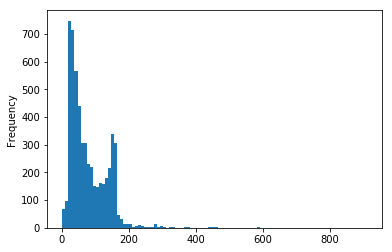

In [13]:
data['length'].plot(bins=100,kind='hist');

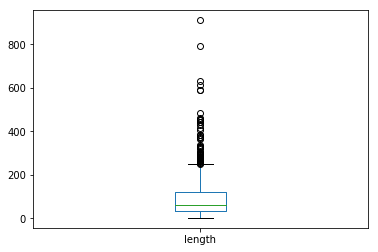

In [15]:
data.length.plot(kind='box');

In [16]:
data.length.describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

We have some messages with extreme lengths (2 and 910, etc) Let's see how they look

In [19]:
data[data.length == 2].message.values

array(['Ok', 'Ok', 'Ok', 'Ok'], dtype=object)

In [21]:
data[data.length == 910].message.values

array(["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."],
      dtype=object)

But let's focus back on the idea of trying to see if message length is a distinguishing feature between **ham** and **spam**

## Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number (or position in text vector).


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words - [**stopwords**](https://en.wikipedia.org/wiki/Stop_words), ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

### Filtering sample text

In [22]:
import string
mess = 'sample message!...'
nopunc=[char for char in mess if char not in string.punctuation]
nopunc=''.join(nopunc)
print(nopunc)

sample message


In [25]:
# import nltk
# nltk.download('stopwords')

In [26]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [27]:
nopunc.split()

['sample', 'message']

In [28]:
clean_mess=[word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [29]:
clean_mess

['sample', 'message']

Now let's put both of these together in a function to apply it to our DataFrame later on:

### Define filtering function

In [36]:
def text_process(message):
    """Remove all punctuation characters from message (one-by-one), join remaining characters back.
    Split remaining text by spaces (space will be separator for getting words/tokens), then remove the words which 
    are in english stopwords list (comparison is done in lowercase), finally we have a list of filtered words"""
    message_nopunct_chars =[char for char in message if char not in string.punctuation]
    message_nopunct=''.join(message_nopunct_chars)
    message_words = message_nopunct.split(sep=' ')
    filtered_message_words = [word for word in message_words if word.lower() not in stopwords.words('english')]
    
    return filtered_message_words

### Tokenize and filter messages

Here is the original DataFrame again:

In [32]:
data.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

**Note:**
We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol)

In [55]:
data['message'].head().apply(text_process).values.tolist()

[['Go', 'jurong', 'point', 'crazy', 'Available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'Cine', 'got', 'amore', 'wat'], ['Ok', 'lar', 'Joking', 'wif', 'u', 'oni'], ['Free', 'entry', '2', 'wkly', 'comp', 'win', 'FA', 'Cup', 'final', 'tkts', '21st', 'May', '2005', 'Text', 'FA', '87121', 'receive', 'entry', 'questionstd', 'txt', 'rateTCs', 'apply', '08452810075over18s'], ['U', 'dun', 'say', 'early', 'hor', 'U', 'c', 'already', 'say'], ['Nah', 'dont', 'think', 'goes', 'usf', 'lives', 'around', 'though']]

In [56]:
data.message.head().values.tolist()

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though"]

### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [59]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(data['message'])
print(len(bow_transformer.vocabulary_))

11307


In [60]:
message4 = data['message'][3]
print(message4)

U dun say so early hor... U c already then say...


Now let's see its vector representation:

In [61]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 3998)	2
  (0, 4553)	1
  (0, 5181)	1
  (0, 6120)	1
  (0, 6138)	1
  (0, 7093)	1
  (0, 9447)	2
(1, 11307)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [62]:
print(bow_transformer.get_feature_names()[3998])
print(bow_transformer.get_feature_names()[9447])

U
say


In [63]:
message4

'U dun say so early hor... U c already then say...'

Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [64]:
messages_bow = bow_transformer.transform(data['message'])

In [65]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of non-zero occurences:', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11307)
Amount of non-zero occurences: 51234


In [66]:
sparsity =(100.0 * messages_bow.nnz/(messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity:{}'.format(round(sparsity)))

sparsity:0


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [67]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9447)	0.5391515179363724
  (0, 7093)	0.438375519235493
  (0, 6138)	0.3183143011307023
  (0, 6120)	0.2991551295536476
  (0, 5181)	0.2969195675145299
  (0, 4553)	0.26585776633899993
  (0, 3998)	0.40924708612713756


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [68]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2906345360714773
8.527076498901426


In [69]:
messages_tfidf=tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11307)


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

## Training Naive Bayes model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

In [89]:
from sklearn.naive_bayes import MultinomialNB

In [90]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, data['label'])

In [91]:
print('predicted:',spam_detect_model.predict(tfidf4)[0])
print('expected:',data.label[3])

predicted: ham
expected: ham


Fantastic! We've developed a model that can attempt to predict spam vs ham classification!

## Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [76]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

In [92]:
from sklearn.metrics import classification_report, confusion_matrix

In [94]:
print(classification_report(data['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In [95]:
print(confusion_matrix(data['label'], all_predictions))

[[4825    0]
 [ 114  633]]


There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" is probably much lower than mis-predicting "ham" as "spam".

In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

## Train Test Split

In [82]:
from sklearn.model_selection import train_test_split

In [116]:
msg_train, msg_test, label_train, label_test = train_test_split(data['message'], 
                                                                data['label'], 
                                                                test_size=0.2, 
                                                                stratify=data['label'])

In [117]:
print(len(msg_train),len(msg_test),len(label_train),len(label_test))

4457 1115 4457 1115


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

### Naive Bayes

In [118]:
from sklearn.pipeline import Pipeline

In [119]:
nb_pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

In [120]:
nb_pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f83156c99d8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [121]:
nb_predictions = nb_pipeline.predict(msg_test)

In [122]:
print(classification_report(nb_predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1006
        spam       0.73      1.00      0.84       109

    accuracy                           0.96      1115
   macro avg       0.87      0.98      0.91      1115
weighted avg       0.97      0.96      0.97      1115



The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

### Support Vector Classifier (SVC)

In [149]:
from sklearn.svm import LinearSVC

In [150]:
svc_pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier', LinearSVC()),
])

In [151]:
svc_pipeline.fit(msg_train, label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f83156c99d8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, i

In [152]:
svc_predictions = svc_pipeline.predict(msg_test)

In [153]:
print(classification_report(svc_predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       979
        spam       0.89      0.98      0.93       136

    accuracy                           0.98      1115
   macro avg       0.94      0.98      0.96      1115
weighted avg       0.98      0.98      0.98      1115



## Conclusions

Finally we saw that SVC was better than Naive Bayes. However, it doesn't happen always. Naive bayes is one of the best [baseline](https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/) models and widely used in text classification (can be used for other tasks also). 

Here we did some feature engineering, some preprocessing of the text which changes the results. You can try your version of text processing using just [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and then compare these models again.

## More Resources

Check out the links below for more info on Natural Language Processing:

[NLTK Book Online](http://www.nltk.org/book/)

[Kaggle Walkthrough](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)